# This Notebook was run in Colab

Install libraries

In [ ]:
!pip install torch torchvision
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaConfig, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import torch
from torch.utils.data import Dataset

# mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')



In [ ]:
# Stance dataset used for fine-tuning are the english sentences form the CompSent-19 dataset

df_train = pd.read_csv('gdrive/MyDrive/data/comparg_train.tsv', sep='\t', encoding='utf-8') #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/data/compsent_train.tsv
df_test = pd.read_csv('gdrive/MyDrive/data/comparg_test.tsv', sep='\t', encoding='utf-8') #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/data/compsent_test.tsv

In [ ]:
# fix labels the labels (0,2,3) -> (0,1,2)
df_train['labels'] = df_train['labels'].replace({2: 1})
df_train['labels'] = df_train['labels'].replace({3: 2})

df_test['labels'] = df_test['labels'].replace({2: 1})
df_test['labels'] = df_test['labels'].replace({3: 2})




In [ ]:
#mask objects: replace the first object with "[FIRST_ENTITY]" and the second object with "[SECOND_ENTITY]" in every sample
import re

def mask_objects(row):
    row["text"] = re.sub(re.escape(row["object_0"]), "[FIRST_ENTITY]", row["answer"], flags=re.IGNORECASE)
    row["text"] = re.sub(re.escape(row["object_1"]), "[SECOND_ENTITY]", row["text"], flags=re.IGNORECASE)
    return row


def transform_data(df):
  df = df.apply(mask_objects,axis=1)
  return df

df_train = transform_data(df_train).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = transform_data(df_test)

In [ ]:
#preview of the train dataset
print(df_train.head())

          object_0 object_1  \
0  Hewlett-Packard     Dell   
1            Apple   Google   
2            pizza  sausage   
3            Apple    Intel   
4           Oracle    MySQL   

                                              answer  labels  \
0  Nokia towered over its rivals in ways that Toy...       0   
1  For better or worse, a majority of people stil...       0   
2  Moral disputes are like disputes about whether...       1   
3  Notice that Apple no longer develop its own pr...       0   
4                           Would Oracle Harm MySQL?       0   

                                                text  
0  Nokia towered over its rivals in ways that Toy...  
1  For better or worse, a majority of people stil...  
2  Moral disputes are like disputes about whether...  
3  Notice that [FIRST_ENTITY] no longer develop i...  
4         Would [FIRST_ENTITY] Harm [SECOND_ENTITY]?  


<Axes: xlabel='labels'>

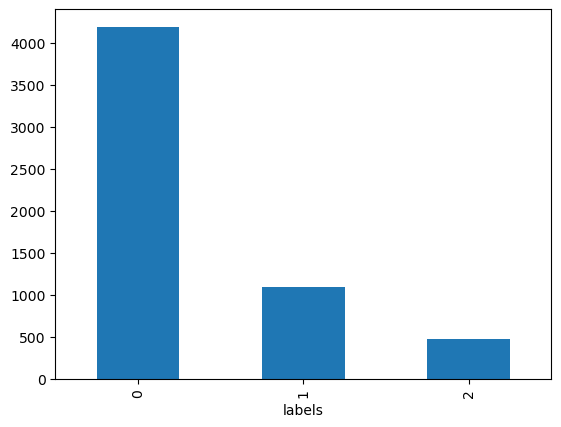

In [ ]:
#trainset class distribution
df_train['labels'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='labels'>

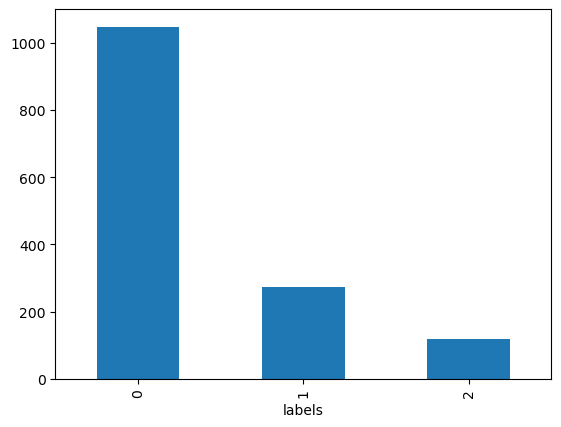

In [ ]:
#testset class distribution
df_test['labels'].value_counts().sort_index().plot(kind='bar')

In [ ]:
#dataset class will take list as input
train_texts = df_train['text'].tolist()
train_labels = df_train['labels'].tolist()
test_texts = df_test['text'].tolist()
test_labels = df_test['labels'].tolist()

In [ ]:
print(train_texts)
print(train_labels)
print(test_texts)
print(test_labels)

## Fine-tune RoBERTa

In [ ]:
#Import RoBERTa-tokenizer for sentiment-analysis from huggingface
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]


        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }





In [ ]:
max_length = 64
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)

In [ ]:
from transformers import set_seed, AutoModelForSequenceClassification
set_seed(42)
model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=3)

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    overwrite_output_dir=True,
    num_train_epochs=5,
    fp16=False, # fp32 precision training
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    output_dir="gdrive/MyDrive/checkpoints",


    )
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    data_collator = data_collator,
    tokenizer = tokenizer,
)

In [ ]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.511500
1000,0.391600
1500,0.272800


TrainOutput(global_step=1800, training_loss=0.36387203640407983, metrics={'train_runtime': 240.89, 'train_samples_per_second': 119.536, 'train_steps_per_second': 7.472, 'total_flos': 4520894406455064.0, 'train_loss': 0.36387203640407983, 'epoch': 5.0})

## Evaluating the fine-tuned RoBERTa

In [ ]:
#predict the testset
outputs = trainer.predict(test_dataset)

In [ ]:
#Extending the Comparative Argumentative Machine: Multilingualism and Stance Detection, Table 1, RoBERTa:
#Results on CompSent-19 testset with RoBERTa trained on CompSent-19 trainset
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

predictions = outputs.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]         #  labels:  0 =  "neutral"  , 1 = "objekt1". , 2 = "objekt2"
print(classification_report(y_true=test_dataset.labels, y_pred=predictions, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_dataset.labels, y_pred=predictions, average='micro')}")


              precision    recall  f1-score   support

     neutral       0.95      0.94      0.94      1048
     objekt1       0.85      0.87      0.86       273
     objekt2       0.68      0.71      0.70       119

    accuracy                           0.91      1440
   macro avg       0.83      0.84      0.83      1440
weighted avg       0.91      0.91      0.91      1440

F1-micro: 0.9076388888888889


In [ ]:
#saving the finetuned model
output_model_dir = 'gdrive/MyDrive/finetuned/roberta_5epoch'
trainer.save_model(output_model_dir)

In [ ]:
#saving the predictions
df_test['preds'] = predictions
df_test.to_csv('gdrive/MyDrive/results/roberta_5epoch_preds.tsv', sep="\t", index=False) #https://github.com/webis-de/ratio24-multilingual-cam/blob/ad8bd12cf7a8be235e689d4042641183212ab87c/results/stance_eng/roberta_5epoch_preds.tsv

In [ ]:
#control if model export worked out
model = AutoModelForSequenceClassification.from_pretrained('gdrive/MyDrive/finetuned/roberta_5epoch')
tokenizer = AutoTokenizer.from_pretrained('gdrive/MyDrive/finetuned/roberta_5epoch')


In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    data_collator = data_collator,
    tokenizer = tokenizer,
)

In [ ]:
outputs = trainer.predict(test_dataset)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

predictions = outputs.predictions.argmax(-1)
target_names = ["neutral", "objekt1", "objekt2"]
print(classification_report(y_true=test_dataset.labels, y_pred=predictions, target_names=target_names))
print(f"F1-micro: {f1_score(y_true=test_dataset.labels, y_pred=predictions, average='micro')}")

              precision    recall  f1-score   support

     neutral       0.95      0.94      0.94      1048
     objekt1       0.85      0.87      0.86       273
     objekt2       0.68      0.71      0.70       119

    accuracy                           0.91      1440
   macro avg       0.83      0.84      0.83      1440
weighted avg       0.91      0.91      0.91      1440

F1-micro: 0.9076388888888889
